In [ ]:
import sys
import os

# Get parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add parent directory to sys.path
sys.path.append(parent_dir)

In [9]:

from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from typing import List, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1]:
from scrape_ids import scrape_ids
from scraper import Scraper
from utils import Utils
from process_ids import run
from config import CARS, RECORDS_FOLDER, DATASET_NAME

# Scrape the dataset

In [ ]:
# # takes criteria specified config, scrapes listing id for all cars, then saves as .txt in data > lisging_ids folder
# scrape_ids(CARS)

In [ ]:
# # runs script to process listing ids from each .txt file into json records with description, price, and other details
# file_prefixes = ['Chevrolet_Camaro_1967_1969','Dodge_Charger_1968_1970','Ford_Bronco_1966_1977','Ford_Mustang_1965_1971']

# for prefix in file_prefixes:
#     run(prefix)
    

In [5]:
# run('Ford_Mustang_1965_1971')
# source ~/anaconda3/Scripts/activate --> conda activate env

# Create Dataframe

In [4]:
from itertools import islice
utils = Utils()

def describe(records: dict, stop: int=10) -> None:
    """
    Describes schema of json dataset. 
    """
    for key, val in records.items():
        not_null = [i for i in val if i]
        print(f"{key} | Example Value: {val[0][:stop] + '...' if isinstance(val[0], str) and len(val[0]) > stop else val[0]}, "
            f"Series Length: {len(val)}, Non Null: {len(not_null)}")
        
def get_slice(records: dict, n: int=2) -> None:
    """
    View arbitrary slices of the records dictionary.
    """
    first_n_items = dict(islice(records.items(), n))
    print(first_n_items)
    
# inspect the json file data
describe(utils.load_records(folder_name=RECORDS_FOLDER, file_name='Ford_Bronco_1966_1977.json'))

listing_id | Example Value: CC-1805153, Series Length: 234, Non Null: 234
title | Example Value: 1973 Ford ..., Series Length: 234, Non Null: 234
description | Example Value: Rebuilt 19..., Series Length: 234, Non Null: 234
price | Example Value: 150000, Series Length: 234, Non Null: 219
city | Example Value: georgetown, Series Length: 234, Non Null: 234
state | Example Value: texas, Series Length: 234, Non Null: 234
location | Example Value: georgetown..., Series Length: 234, Non Null: 234
year | Example Value: 1973, Series Length: 234, Non Null: 234
make | Example Value: ford, Series Length: 234, Non Null: 234
model | Example Value: bronco, Series Length: 234, Non Null: 234
exterior_color | Example Value: teal, Series Length: 234, Non Null: 202
interior_color | Example Value: parchment ..., Series Length: 234, Non Null: 178
transmission | Example Value: automatic, Series Length: 234, Non Null: 193
engine_size | Example Value: v-8, Series Length: 234, Non Null: 46
odometer | Example V

In [5]:

# create a dataframe by collecting all records from json files, but only keeping specified columns.
cols = ['listing_id','title','description','price','city','state','year','make','model','transmission','exterior_color','interior_color']
files = ['Dodge_Charger_1968_1970.json','Chevrolet_Camaro_1967_1969.json','Ford_Bronco_1966_1977.json','Ford_Mustang_1965_1971.json']


all_df = pd.DataFrame(columns=cols) 

for file in files:
    records = utils.load_records(folder_name=RECORDS_FOLDER, file_name=file)
    records = {k:v for k,v in records.items() if k in cols}
    df = pd.DataFrame.from_dict(records)
    df['model'] = df['model'].mode()[0] # normalize model name
    df['category'] = df.apply(lambda row: f"{row['year']}_{row['make']}_{row['model']}", axis=1)
    all_df = pd.concat([all_df, df], ignore_index=True)
    
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1995 entries, 0 to 1994
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   listing_id      1995 non-null   object 
 1   title           1995 non-null   object 
 2   description     1984 non-null   object 
 3   price           1866 non-null   float64
 4   city            1995 non-null   object 
 5   state           1995 non-null   object 
 6   year            1995 non-null   object 
 7   make            1995 non-null   object 
 8   model           1995 non-null   object 
 9   transmission    1735 non-null   object 
 10  exterior_color  1778 non-null   object 
 11  interior_color  1578 non-null   object 
 12  category        1995 non-null   object 
dtypes: float64(1), object(12)
memory usage: 202.7+ KB


C:\Users\achil\Temp\ipykernel_207084\2140661714.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_df = pd.concat([all_df, df], ignore_index=True)


In [6]:
all_df.head()

,listing_id,title,description,price,city,state,year,make,model,transmission,exterior_color,interior_color,category
0,CC-1914567,1969 Dodge Charger R/T,1969 gorgeous Dodge Charger RT/SE restored. Ow...,99000.0,dallas,texas,1969,dodge,charger,automatic,gold,green,1969_dodge_charger
1,CC-1919610,1968 Dodge Charger,General Lee Replica\n383 CI V-8 Engine\nAutoma...,NaN,greensboro,north carolina,1968,dodge,charger,None,orange,red,1968_dodge_charger
2,CC-1919743,1968 Dodge Charger,Bright red 1968 Dodge Charger R/T with black b...,NaN,des moines,iowa,1968,dodge,charger,manual,bright red,black,1968_dodge_charger
3,CC-1919296,1970 Dodge Charger,413CID Engine\nTwo 4 BBL Carburetors\nAutomati...,NaN,greensboro,north carolina,1970,dodge,charger,None,blue,black/blue,1970_dodge_charger
4,CC-1918573,1970 Dodge Charger,"One of one. Award winning, rotisserie restored...",NaN,des moines,iowa,1970,dodge,charger,manual,b3 light blue metallic,two tone b5 and b7 blue,1970_dodge_charger


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


# EDA
Taking a look at the dataset statistics

In [38]:
# get series to plot data distributions
words = all_df['title'].str.split().str.len() + all_df['description'].str.split().str.len()
prices = all_df['price']



## Category Counts
I did light feature engineering by making 'Category'. Category is a compination of make, model, and year. 
- The most popular cars are pre 1970 Camaros and Mustangs. Bronco's are the most rare by year, but there are less than 90 total Dodge Chargers in the dataset (I only took the 'best' years).
- The box plot shows that the IQRs are stratified by model with frequent outliers across most model years.

In [8]:
all_df['category'].value_counts()

category
1965_ford_mustang        291
1969_chevrolet_camaro    282
1966_ford_mustang        252
1967_chevrolet_camaro    160
1968_chevrolet_camaro    157
1968_ford_mustang        137
1967_ford_mustang        108
1970_ford_mustang         86
1969_ford_mustang         66
1970_chevrolet_camaro     53
1974_ford_bronco          38
1971_ford_mustang         35
1970_dodge_charger        35
1969_ford_bronco          30
1968_dodge_charger        27
1971_chevrolet_camaro     27
1970_ford_bronco          25
1969_dodge_charger        24
1973_ford_bronco          21
1972_chevrolet_camaro     21
1966_ford_bronco          19
1977_ford_bronco          17
1972_ford_bronco          16
1967_ford_bronco          15
1968_ford_bronco          14
1976_ford_bronco          14
1971_ford_bronco          14
1975_ford_bronco          11
Name: count, dtype: int64

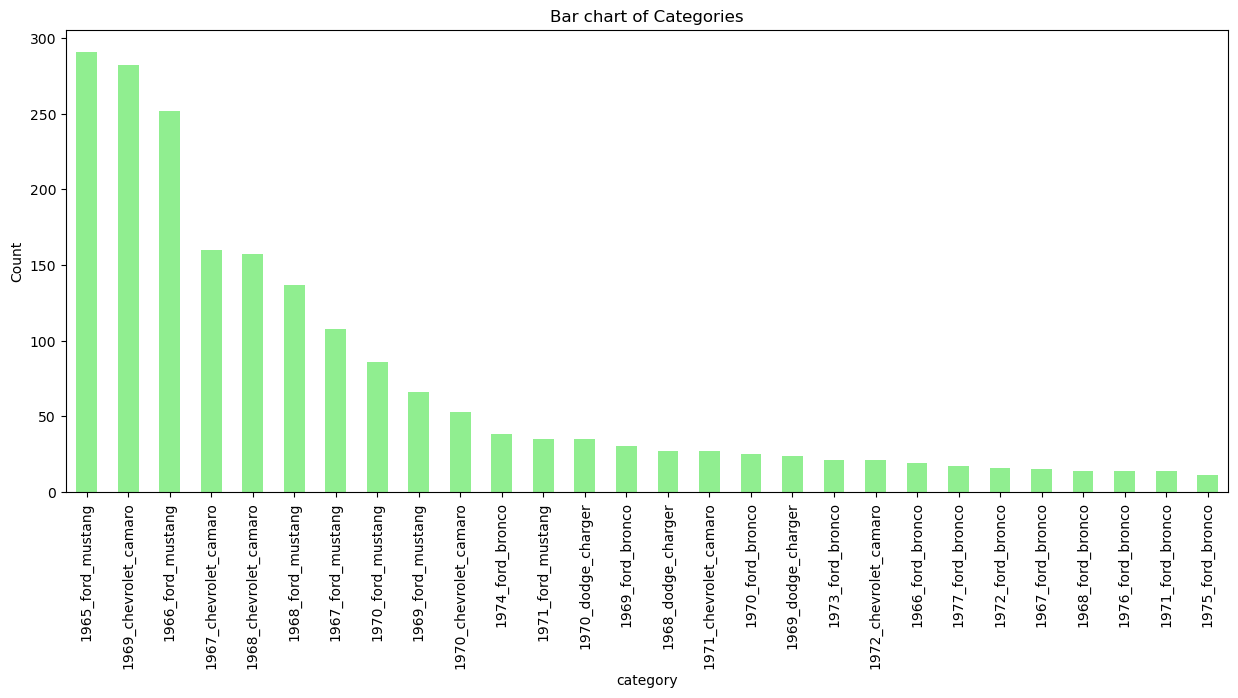

In [11]:
def plot_bar(data: pd.Series, title: str, color: str) -> None:
    category_counts = data.value_counts()
    plt.figure(figsize=(15,6))
    plt.title(f'Bar chart of {title}')
    plt.xlabel(f'{title}')
    plt.ylabel('Count')  
    plt.xticks(rotation=45)
    category_counts.plot(kind='bar', color=color)
    plt.show()
    
plot_bar(data=all_df['category'], title='Categories', color='lightgreen')

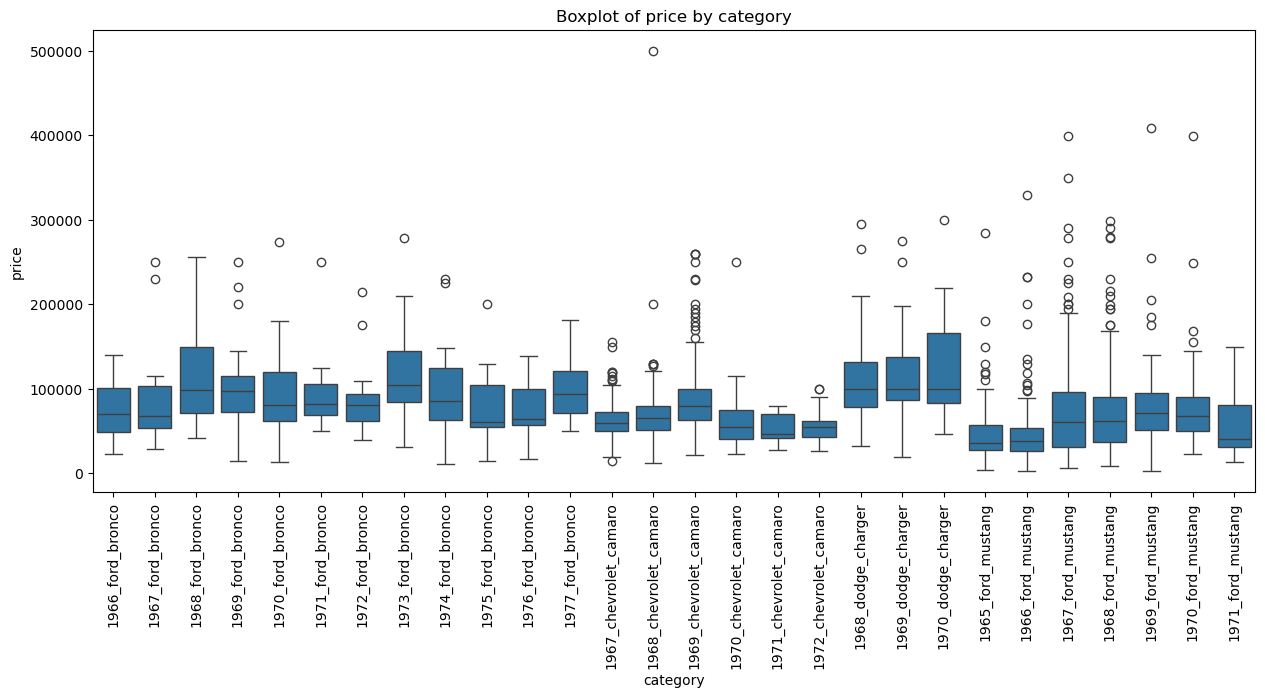

In [35]:
# order box plot
sorted_values = all_df.sort_values(by=['model','year'])['category'].unique()

def plot_box(data: pd.DataFrame, groups: str, values: str, sort: list = None) -> None:
    
    plt.figure(figsize=(15,6))
    sns.boxplot(x=groups, y=values, data=data, order=sort)
    
    plt.title(f'Boxplot of {values} by {groups}')
    plt.xlabel(groups)
    plt.ylabel(values)
    plt.xticks(rotation=90)
    plt.show()
    
plot_box(data=all_df, groups='category', values='price',sort=sorted_values)

## Word Count
Description length is mainly in the 50-400

In [10]:
# plot distribution of Character lengths in each description
def plot_hist(data: pd.Series, title: str, color: str, bin_min: int, bin_max: int, bin_size: int) -> None:
    plt.figure(figsize=(15, 6))
    plt.title(f'Histogram of {title} \nAvg: {data.sum()*1.0/len(data):,.0f} / Highest: {data.max():,}')
    plt.xlabel(f'{title}')
    plt.ylabel('Count')
    plt.hist(data, rwidth=0.7, color=color, bins=range(bin_min,bin_max,bin_size))
    plt.show()

plot_hist(data=words, title='Word Count', color='lightblue', bin_min=0, bin_max=1300, bin_size=10)

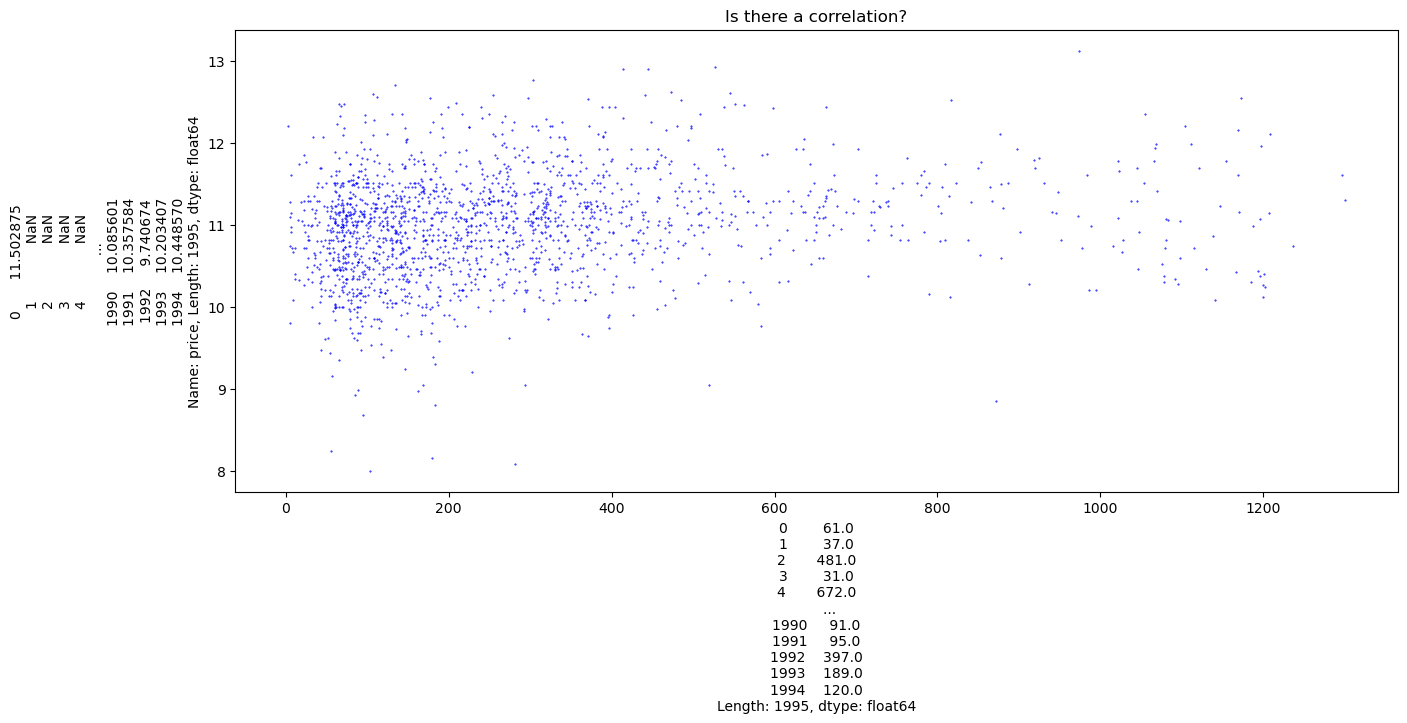

In [48]:
import numpy as np
# is there a relationship between word count and price?
def plot_scatter(x: pd.Series, y: pd.Series, size: float=0.2, color: str='blue'):
    plt.figure(figsize=(15,6))
    plt.scatter(x, y, s=size, color=color)
    plt.xlabel(f'{x}')
    plt.ylabel(f'{y}')
    plt.title(f'Is there a correlation?')
    plt.show()
    
plot_scatter(x=words, y=np.log(prices))


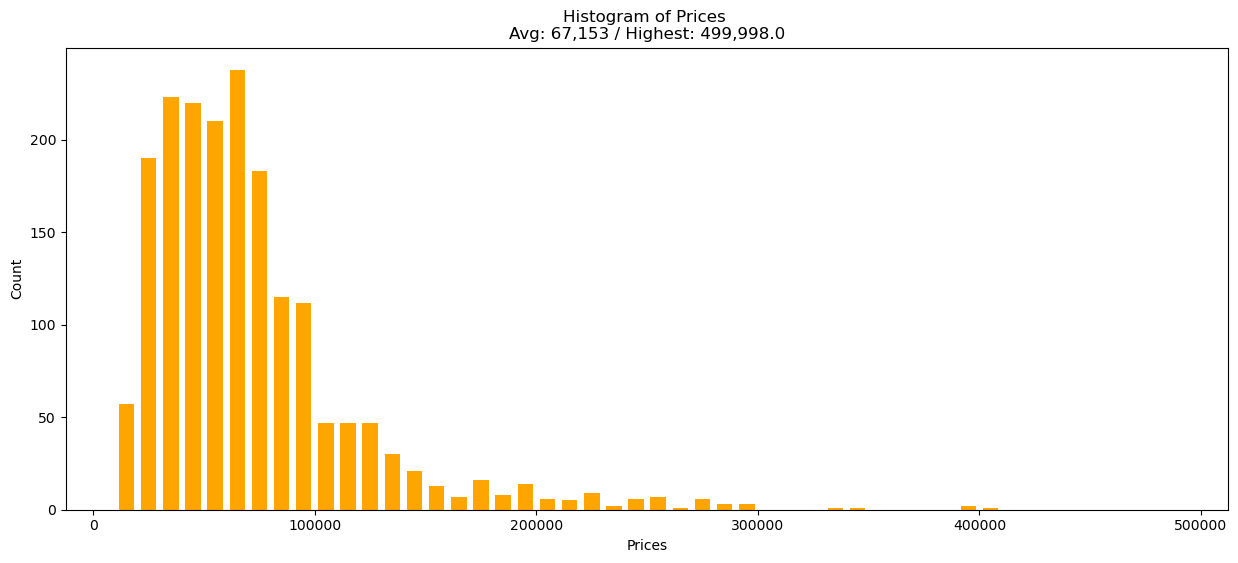

In [13]:
# plot the distribution of prices

plot_hist(data=prices, title='Prices', color='orange', bin_min=10000, bin_max=500000, bin_size=10000)

In [14]:
# check out expensive items
all_df[all_df['price'] > 400000]

,listing_id,title,description,price,city,state,year,make,model,transmission,exterior_color,interior_color,category
718,CC-1801067,1968 Chevrolet Camaro,"Ultra rare Motion Performance 427, 1/4 mile re...",499998.0,volo,illinois,1968,chevrolet,camaro,None,tuxedo black,black,1968_chevrolet_camaro
1034,CC-1792448,1969 Ford Mustang,We are proud to present this unique Mach 1 Mus...,409000.0,québec,quebec,1969,ford,mustang,manual,red,red,1969_ford_mustang


In [7]:
# from database import insert_data
## loads data into database table in chunks
# insert_data(all_df)

In [2]:
from loaders import ItemLoader

loader = ItemLoader()

In [3]:
loader.fetch_items()

Processed 45 items (offset: 0)
Processed 46 items (offset: 50)
Processed 48 items (offset: 100)
Error creating Item object: 'NoneType' object has no attribute 'split'
Error creating Item object: 'NoneType' object has no attribute 'split'
Failed to create item: cannot convert float NaN to integer
Failed to create item: cannot convert float NaN to integer
Processed 42 items (offset: 150)
Failed to create item: cannot convert float NaN to integer
Processed 48 items (offset: 200)
Processed 47 items (offset: 250)
Processed 44 items (offset: 300)
Processed 46 items (offset: 350)
Processed 49 items (offset: 400)
Failed to create item: cannot convert float NaN to integer
Processed 47 items (offset: 450)
Processed 48 items (offset: 500)
Failed to create item: cannot convert float NaN to integer
Processed 48 items (offset: 550)
Failed to create item: cannot convert float NaN to integer
Processed 42 items (offset: 600)
Failed to create item: cannot convert float NaN to integer
Processed 48 items 

In [4]:
loader.category_counts

Counter({'1965_ford_mustang': 256,
         '1969_chevrolet_camaro': 244,
         '1966_ford_mustang': 224,
         '1967_chevrolet_camaro': 146,
         '1968_chevrolet_camaro': 142,
         '1968_ford_mustang': 113,
         '1967_ford_mustang': 96,
         '1970_ford_mustang': 78,
         '1969_ford_mustang': 58,
         '1970_chevrolet_camaro': 48,
         '1974_ford_bronco': 33,
         '1970_dodge_charger': 31,
         '1969_ford_bronco': 28,
         '1971_ford_mustang': 28,
         '1970_ford_bronco': 25,
         '1971_chevrolet_camaro': 23,
         '1968_dodge_charger': 23,
         '1969_dodge_charger': 20,
         '1972_chevrolet_camaro': 19,
         '1973_ford_bronco': 18,
         '1966_ford_bronco': 16,
         '1972_ford_bronco': 15,
         '1971_ford_bronco': 14,
         '1977_ford_bronco': 13,
         '1967_ford_bronco': 13,
         '1976_ford_bronco': 13,
         '1968_ford_bronco': 12,
         '1975_ford_bronco': 10})

In [5]:
loader.train_test_split()

In [7]:
# # load train and test sets to HuggingFace Hub
# loader.upload_prompts_to_HFhub()

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [6]:
# loader.pickle(folder_name=DATASET_FOLDER)